In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
# import coffea
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, DelphesSchema

In [2]:
import vector
def packVector3D(pt,phi,eta):
    vec3d = ak.Array(
        {
            "rho": pt,
            "phi": phi,
            "eta": eta,
        },
        with_name="Vector3D"
    )
    return vec3d

In [4]:
events = NanoEventsFactory.from_root(
    # "whgbkg1_p.root",
    "btest.root",
    # "whg_lo_pp_vlh_decay_dd.root",
    schemaclass=DelphesSchema,
    treepath="Delphes",
).events()
eve_dic={}
for branch in events.fields:
    eve_dic[branch] = events[branch]
eve_ak = ak.Array(eve_dic)
def readDelphes(name):
    events = NanoEventsFactory.from_root(
        name,
        schemaclass=DelphesSchema,
        treepath="Delphes",
    ).events()
    return events

In [6]:
flavor=events["Jet"].Flavor

In [7]:
Photon = ak.copy(events.Photon)
Electron = ak.copy(events.Electron)
# 确保两个数组都不为空
has_photon = ak.num(Photon, axis=1) > 0
has_electron = ak.num(Electron, axis=1) > 0
has_both = has_photon & has_electron

# 只对有 photon 和 electron 的事件计算
photon_with_both = Photon[has_both]
electron_with_both = Electron[has_both]

if ak.sum(has_both) > 0:
    photon_electron_pairs = ak.cartesian([photon_with_both, electron_with_both], axis=1)
    delta_r_result = photon_electron_pairs['0'].delta_r(photon_electron_pairs['1'])
    print("有效事件的 photon-electron delta_r:")
    print(delta_r_result)
else:
    print("没有同时包含 photon 和 electron 的事件")


有效事件的 photon-electron delta_r:
[[2.33], [1.68], [0.991], [1.89], [1.47], ... [2.29], [2.9], [1.53], [2.98], [0.831]]


In [8]:
print(flavor)

[[5, 4, 5, 2, 3, 21], [21, 5, 1, 4, 2, 5, ... 1, 2, 1, 2, 0, 21], [0, 5, 0, 4, 0, 3]]


In [9]:
btag= events["Jet"].BTag

In [10]:
print("btag",btag & 2)
print(ak.sum(btag>1))
type(btag[1][1])

btag [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], ... 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
0


int

In [11]:
print((btag>>4)&1)

[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], ... 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]


In [56]:
events.fields

['FatJet.offsets',
 'FatJet',
 'Event.offsets',
 'Event',
 'MissingET.offsets',
 'MissingET',
 'EFlowTrack.offsets',
 'EFlowTrack',
 'GenJet.offsets',
 'GenJet',
 'EFlowNeutralHadron.offsets',
 'EFlowNeutralHadron',
 'Jet.offsets',
 'Jet',
 'Weight.offsets',
 'Weight',
 'Tower.offsets',
 'Tower',
 'Track.offsets',
 'Track',
 'EFlowPhoton.offsets',
 'EFlowPhoton',
 'Electron.offsets',
 'Electron',
 'Muon.offsets',
 'Muon',
 'Photon.offsets',
 'Photon',
 'Particle.offsets',
 'Particle',
 'GenMissingET.offsets',
 'GenMissingET',
 'ScalarHT.offsets',
 'ScalarHT']

some function usage examples

In [55]:
def countItem(arr, item):
    count = 0
    for i in arr:
        if i == item:
            count += 1
    return count
import awkward as ak

def mergeAndMasks(*masks):
    """Merge multiple awkward boolean masks with logical AND."""
    if len(masks) == 0:
        raise ValueError("At least one mask is required")
    
    merged_mask = masks[0]
    for mask in masks[1:]:
        merged_mask = merged_mask & mask
    return merged_mask

def mergeOrMasks(*masks):
    """OR-combine boolean masks."""
    if len(masks) == 0:
        raise ValueError("At least one mask is required")
    
    merged_mask = masks[0]
    for mask in masks[1:]:
        merged_mask = merged_mask | mask  # Use | instead of 'or' for element-wise operation
    return merged_mask

def mergeXorMasks(mask1, mask2):
    """
    Merge two boolean masks using logical XOR operation.
    Result is True when exactly one of the masks is True.
    
    Args:
        mask1: First boolean awkward array
        mask2: Second boolean awkward array
        
    Returns:
        awkward array: Combined mask using XOR operation
    """
    merged_mask = mask1 ^ mask2
    return merged_mask

# Additional utility functions for mask operations
def mergeNotMask(mask):
    """Invert a boolean mask."""
    return ~mask

def countPassingEvents(mask):
    """Count True entries in a mask."""
    return ak.sum(mask==True)

def getEfficiency(mask, total_events=None):
    """Compute mask efficiency (passing/total)."""
    passing = ak.sum(mask==True)
    total = total_events if total_events is not None else len(mask)
    return float(passing) / float(total)

def combineMasks(masks_dict, operation='and'):
    """Combine named masks with AND/OR."""
    mask_list = list(masks_dict.values())
    op = operation.lower()
    if op == 'and':
        return mergeAndMasks(*mask_list)
    elif op == 'or':
        return mergeOrMasks(*mask_list)
    else:
        raise ValueError("Operation must be 'and' or 'or'")

print("Enhanced mask functions loaded successfully!")

Enhanced mask functions loaded successfully!


Cuts define:

In [112]:
def goodLepton(events, pt_cut=10.0, eta_cut=2.5):
    """
    安全的轻子选择，只使用基本动力学变量
    """
    # good_electron_mask = ak.zeros_like(events.event, dtype=bool)
    # good_muon_mask = ak.zeros_like(events.event, dtype=bool)
    
    # 安全处理电子
    if "Electron" in events.fields:
        try:
            electron_count = ak.num(events.Electron, axis=1)
            if ak.max(electron_count) > 0:
                e_pt = events.Electron.PT
                e_eta = events.Electron.Eta
                
                e_cuts = (e_pt > pt_cut) & (np.abs(e_eta) < eta_cut)
                good_electron_mask = e_cuts
                print(f"Processed {ak.sum(electron_count)} electrons successfully")
        except Exception as e:
            print(f"Skipping electrons due to error: {e}")
    
    # 安全处理缪子
    if "Muon" in events.fields:
        try:
            muon_count = ak.num(events.Muon, axis=1)
            if ak.max(muon_count) > 0:
                mu_pt = events.Muon.PT
                mu_eta = events.Muon.Eta
                
                mu_cuts = (mu_pt > pt_cut) & (np.abs(mu_eta) < eta_cut)
                good_muon_mask = mu_cuts
                print(f"Processed {ak.sum(muon_count)} muons successfully")
        except Exception as e:
            print(f"Skipping muons due to error: {e}")
    
    return good_electron_mask, good_muon_mask

def goodPhoton(events, pt_cut=10.0, eta_cut=2.5):
    """ select Photon with |eta| < etacut(2.5) and PT > ptcut(10.0) """
    Photon = ak.copy(events.Photon)
    exist_mask = ak.num(Photon, axis=1) > 0
    ptcut = Photon.PT > pt_cut           # PT > 10 GeV
    etacut = np.abs(Photon.Eta) < eta_cut  # |eta| < 2.5
    good_photon_cut = ptcut & etacut
    has_good_photon = ak.any(good_photon_cut, axis=1)
    mask = exist_mask & has_good_photon
    return mask

In [120]:
goodElectron, goodMuon = goodLepton(events,pt_cut=0.0, eta_cut=1)
goodPhotonMask = goodPhoton(events)
print("Good Electron mask:", goodElectron)
print("Good Muon mask:", goodMuon)
print("Good Photon mask:", goodPhotonMask)
# plt.hist(ak.sum(goodElectron==True, axis=1))

Processed 136 electrons successfully
Processed 131 muons successfully
Good Electron mask: [[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]
Good Muon mask: [[], [], [], [], [True], [True], [], [], ... [], [], [], [True], [], [], [], []]
Good Photon mask: [False, False, True, True, False, True, ... True, False, False, True, True, True]


In [109]:
def missptOverCut(events, cut):
    # Check if MissingET.MET is greater than threshold
    mask = events["MissingET"].MET > cut
    return mask

def containBjet(events, num):
    #Check if events contain exactly the specified number of b-tagged jets
    Btag = events["Jet"].BTag
    btag_count = ak.sum(Btag == 1, axis=1)
    mask = btag_count == num
    return mask

def countElectron(events):
    #Count the number of electrons in each event (both positive and negative charges)
    # Use ak.num to directly count electrons in each event
    electron_count = ak.num(events["Electron"], axis=1)
    return electron_count

def countMuon(events):
    #Count the number of muons in each event (both positive and negative charges)
    # Use ak.num to directly count muons in each event
    muon_count = ak.num(events["Muon"], axis=1)
    return muon_count

def leptonTrigger(events):
    #Check if events have exactly 1 lepton (electron + muon total = 1)
    electron_count = ak.num(events["Electron"], axis=1)
    muon_count = ak.num(events["Muon"], axis=1)
    total_lepton_count = electron_count + muon_count
    mask = total_lepton_count == 1
    return mask

def singleLeptonTrigger(events):
    # Check if events have exactly 1 good lepton (electron or muon)
    good_electron_mask, good_muon_mask = goodLepton(events)
    good_electron_count = ak.sum(good_electron_mask, axis=1)
    good_muon_count = ak.sum(good_muon_mask, axis=1)
    total_good_lepton_count = good_electron_count + good_muon_count
    mask = total_good_lepton_count == 1
    return mask

def tightElectron(events, cut):
    #Check if events have exactly 1 electron with PT > cut
    electron_pt = events["Electron"].PT
    # Count electrons with PT > cut in each event
    tight_electron_count = ak.sum(electron_pt > cut, axis=1)
    mask = tight_electron_count == 1
    return mask

def tightMuon(events, cut):
    # Check if events have exactly 1 muon with PT > cut
    muon_pt = events["Muon"].PT
    # Count muons with PT > cut in each event
    tight_muon_count = ak.sum(muon_pt > cut, axis=1)
    mask = tight_muon_count == 1
    return mask

print("Functions loaded successfully")


Functions loaded successfully


In [110]:
mask_signleLepton = singleLeptonTrigger(events)
print("Single lepton trigger mask:", mask_signleLepton)

Processed 136 electrons successfully
Processed 131 muons successfully
Single lepton trigger mask: [False, False, False, False, True, True, ... False, True, False, False, False, False]


In [16]:
# btag=events['Jet'].BTag
# ak.num(btag, axis=1)
# local_index = ak.local_index(btag)
# combination

cut Events

In [48]:

def eventCut(events):
    maskmisspt = missptOverCut(events, 30)
    maskBjets = containBjet(events, 1)
    maskLepTrig = leptonTrigger(events)
    
    maskElec = tightElectron(events, 30)
    maskMuon = tightMuon(events, 26)
    maskLepPT = mergeOrMasks(maskElec, maskMuon)
    merged_mask = mergeAndMasks(maskmisspt, maskBjets, maskLepTrig)
    
    cutnum = countItem(merged_mask, True)
    text= f"Before cut: {len(events)} events, After cut: {len(events[merged_mask])} events"
    print(text)
    return merged_mask

# events = events[merged_mask]

In [18]:
def getWMass(events):
    missMET = events["MissingET"].MET
    missPhi = events["MissingET"].Phi
    ###
    # because we has limit lepton == 1, we just sum lepton PT and phi
    ###
    leptonPT = ak.sum(events["Electron"].PT, axis=1) + ak.sum(events["Muon"].PT, axis=1)
    leptonPhi = ak.sum(events["Electron"].Phi, axis=1) + ak.sum(events["Muon"].Phi, axis=1)
    ###
    # Reconstruct the transverse mass of W boson
    ###
    W_mass = np.sqrt(2 * leptonPT * missMET * (1 - np.cos(leptonPhi - missPhi)))
    return W_mass

def getBBmass(events):
    # 选出 b-jets
    bjets = events["Jet"][events["Jet"].BTag == 1]
    # 按 PT 降序排列
    bjets = bjets[ak.argsort(bjets.PT, axis=1, ascending=False)]
    # 取前两个 bjets
    leading2 = bjets[:, :2]
    # 计算四矢量分量
    px = leading2.PT * np.cos(leading2.Phi)
    py = leading2.PT * np.sin(leading2.Phi)
    pz = leading2.PT * np.sinh(leading2.Eta)
    E  = np.sqrt(leading2.Mass**2 + px**2 + py**2 + pz**2)
    # 合并成总四矢量
    px_sum = ak.sum(px, axis=1)
    py_sum = ak.sum(py, axis=1)
    pz_sum = ak.sum(pz, axis=1)
    E_sum  = ak.sum(E,  axis=1)
    # 计算不变质量
    mass2 = E_sum**2 - px_sum**2 - py_sum**2 - pz_sum**2
    bbmass = np.sqrt(np.maximum(mass2, 0))  # 防止负数开根号
    return bbmass
    


    # return bjet_mass
def getNjet(events):
    # get the number of jets in each event
    njet = ak.num(events["Jet"].BTag, axis=1)
    return njet
    

In [19]:
event_btag = ak.sum(events["Jet"].BTag, axis=1)


(0.0, 5.0)

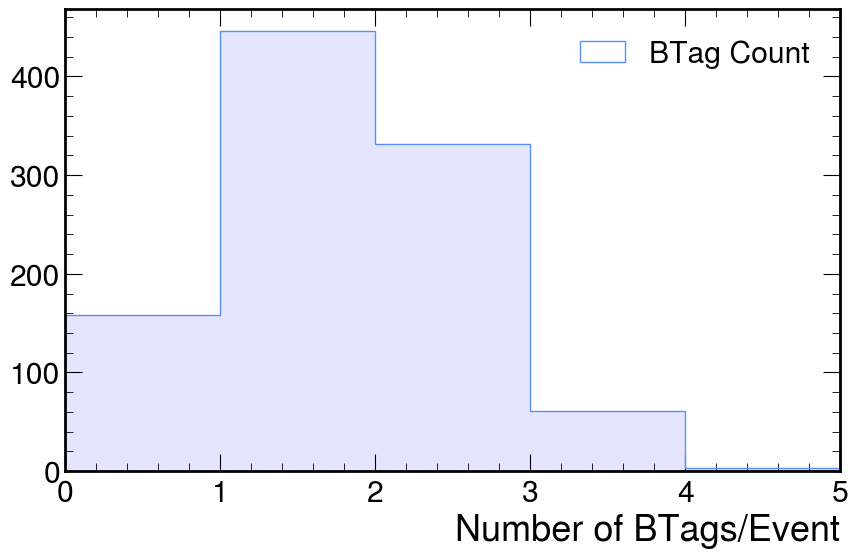

In [20]:
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.figure(figsize=(10, 6))
plt.hist(event_btag, bins=10, range=(0, 10), histtype='step', label='BTag Count') 
plt.hist(event_btag, bins=10, range=(0, 10), color='blue', alpha=0.1)
plt.xlabel('Number of BTags/Event')
plt.legend()
plt.xlim(0, 5)


In [46]:
maskmisspt = missptOverCut(events, 30)
maskBjets = containBjet(events, 1)
maskLepTrig = leptonTrigger(events)

maskElec = tightElectron(events, 30)
maskMuon = tightMuon(events, 26)
maskLepPT = mergeOrMasks(maskElec, maskMuon)
merged_mask = mergeAndMasks(maskmisspt, maskBjets, maskLepTrig)

cutnum = countItem(merged_mask, True)
text= f"Before cut: {len(events)} events, After cut: {len(events[merged_mask])} events"
print(text)

Before cut: 1000 events, After cut: 84 events


In [49]:
event_cut_mask = eventCut(events)
events_cut = events[event_cut_mask]
W_mass = getWMass(events_cut)


Before cut: 1000 events, After cut: 84 events


In [50]:
bb_mass = getBBmass(events_cut)
print(bb_mass)
bjetmask = events_cut["Jet"].BTag == 1 
print(bjetmask)
# using slicing
first_bjet_pt = events_cut["Jet"].PT[bjetmask][:, 0]
print(first_bjet_pt)
def saveAsNPY(events, filename):
    """
    Save the events as a numpy file.
    """
    np.save(filename, ak.to_numpy(events))
    print(f"Events saved to {filename}")

saveAsNPY(bb_mass, "bb_mass.npy")

[17.5, 10.1, 10.4, 18.3, 9.47, 5, 7.94, ... 7.08, 10.9, 13, 7.86, 9.01, 12.3, 11.3]
[[True, False, False, False, False], ... False, False, False, False, False, False]]
[223, 55.6, 96.9, 88.3, 36.9, 24.5, 60.9, ... 31.9, 135, 103, 37, 65.2, 92.9, 124]
Events saved to bb_mass.npy


In [51]:
bb_mass = np.load("bb_mass.npy")

(array([ 0.,  1.,  2., 15., 16., 17.,  6.,  5.,  3.,  5.,  1.,  1.,  3.,
         2.,  0.,  1.,  0.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
        110., 112., 114., 116., 118., 120., 122., 124., 126., 12

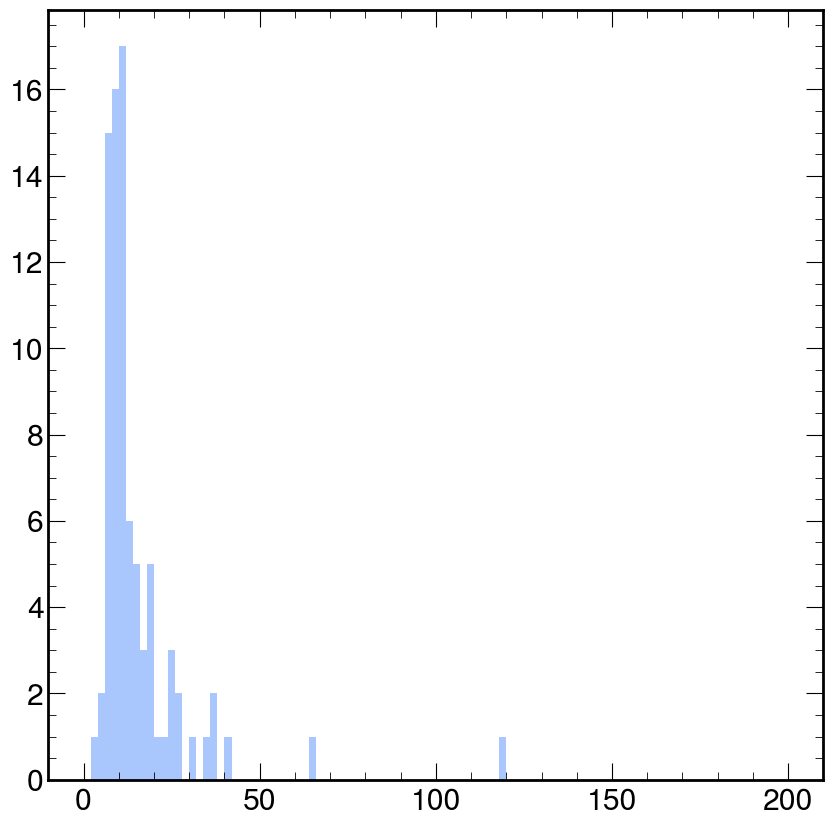

In [52]:
plt.hist(bb_mass, bins=100, range=(0, 200), alpha=0.5, label='bb mass')

(array([2., 2., 0., 1., 2., 2., 2., 4., 0., 0., 6., 2., 1., 4., 1., 6., 3.,
        6., 7., 2., 6., 5., 1., 2., 2., 2., 1., 2., 2., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 [<matplotlib.patches.Polygon at 0x7f53f2247c40>])

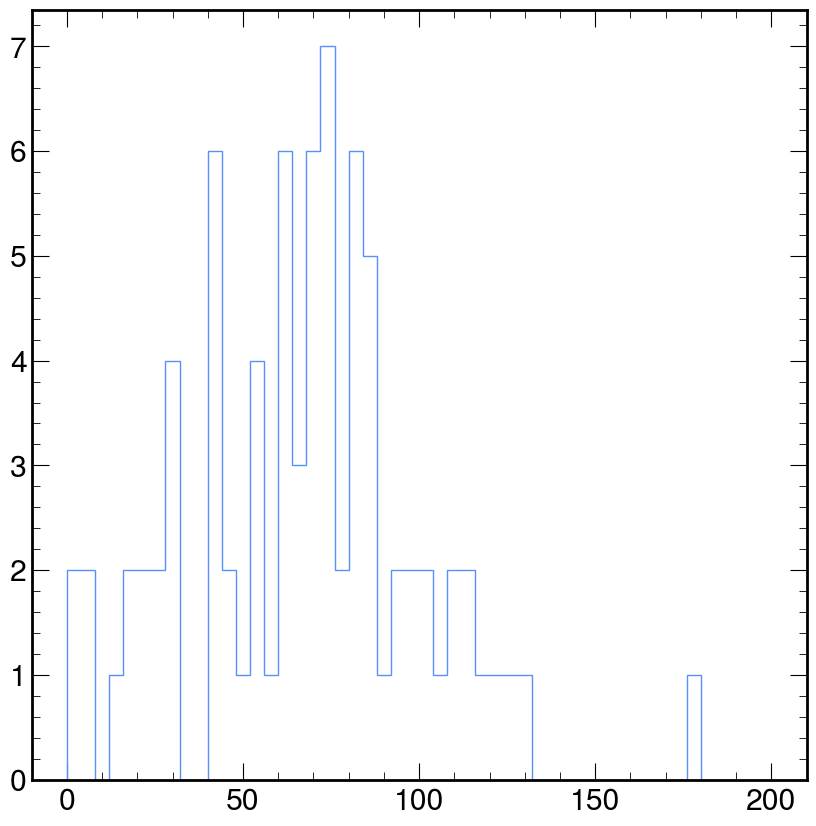

In [53]:
plt.hist(W_mass, bins=50, range=(0, 200), histtype='step', label='W Mass Distribution')

In [54]:

# Btag = events["Jet"].BTag
# print(Btag)
# print("Btag length:", len(Btag))
# for i in Btag:
#     print(i)
#     count_ones = countItem(i, 1)
#     print(f"Number of elements equal to 1: {count_ones}")